# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import seaborn as sns
import statsmodels.api as sm
import warnings
from pathlib import Path
warnings.filterwarnings(action='once')

dataPath = str(Path(os.getcwd()).parent.absolute())+"/data"
figuresPath = str(Path(os.getcwd()).parent.absolute())+"/reports/figures"

# Loading data

In [2]:
portfoliosExcessReturns = pd.read_excel(dataPath+"/raw/monthly_returns_by_industry.xlsx",index_col=0,header=1,sheet_name="Excess returns")
portfoliosTotalReturns = pd.read_excel(dataPath+"/raw/monthly_returns_by_industry.xlsx",index_col=0,header=1,sheet_name="Total Returns")
ff = pd.read_excel(dataPath+"/raw/monthly_returns_by_industry.xlsx",index_col=0,header=1,sheet_name="Fama-French factors")/100
#portfoliosExcessReturns

# Cleaning/preparing the data

In [3]:
#check NaN values
print(portfoliosExcessReturns.isnull().sum().sum())
print(portfoliosTotalReturns.isnull().sum().sum())
print(ff.isnull().sum().sum())

0
0
0


In [4]:
#index to date-time format (need some changes in order to use last day of the month, not the first)
portfoliosExcessReturns.set_index(pd.to_datetime(portfoliosExcessReturns.index,format= "%Y%m"), inplace=True)
portfoliosTotalReturns.set_index(portfoliosExcessReturns.index, inplace=True)
ff.set_index(portfoliosExcessReturns.index, inplace=True)

# Data descriptive/summary statistics and key insight
Yearly returns, best portfolios

In [5]:
#create cumulative returns 
cumulativeExcessReturns = (portfoliosExcessReturns + 1).cumprod()
cumulativeTotalReturns = (portfoliosTotalReturns + 1).cumprod()

In [6]:
#create average returns 
averageReturns = pd.DataFrame()
averageReturns["Total period returns"] =  cumulativeTotalReturns.iloc[-1].sort_values()
averageReturns["Average yearly returns"] =  averageReturns["Total period returns"]**(1/24)
averageReturns["Average monthly returns"] =  averageReturns["Average yearly returns"]**(1/12)
#averageReturns

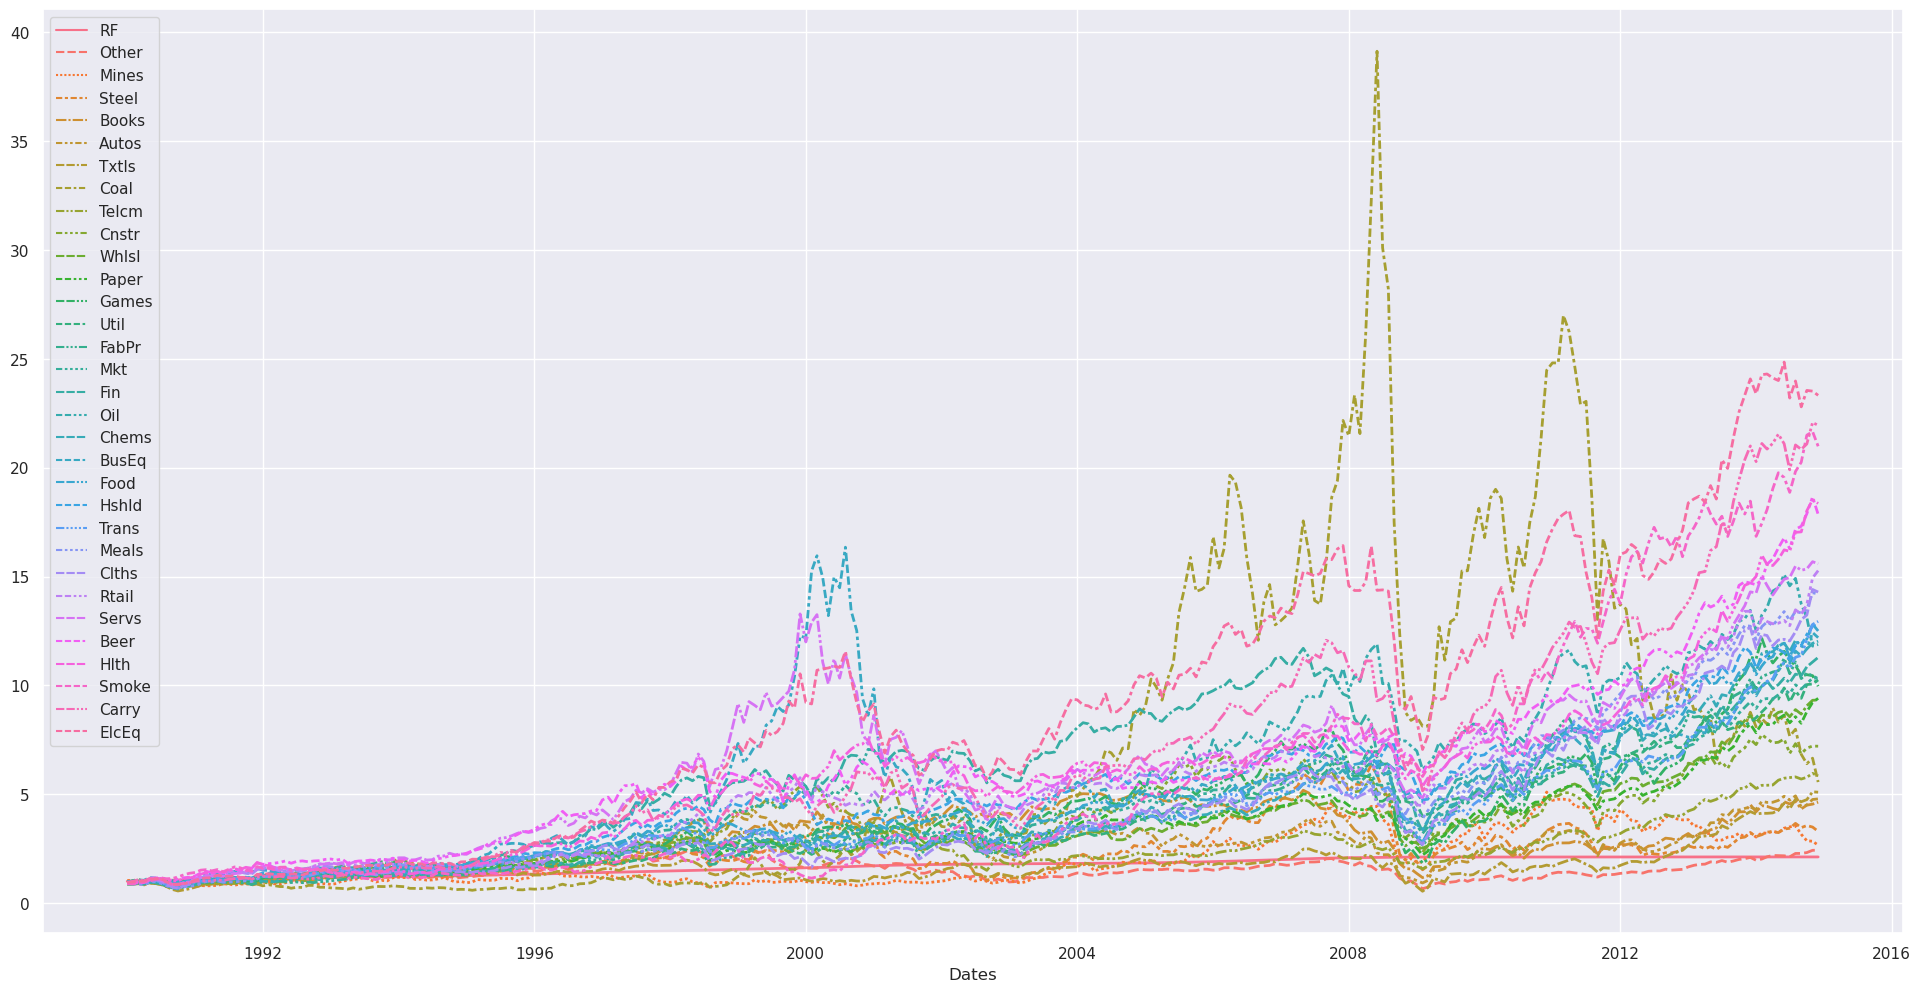

In [7]:
sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.lineplot(data=cumulativeTotalReturns.loc[:, cumulativeTotalReturns.iloc[-1].sort_values().index],linewidth = 2.0 )
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/cumulativeTotalReturns.png")

# Estimation of the CAPM and Fama-French Model
4. Estimate the CAPM, and then Fama-French model for each industry portfolio.
5. Summarize the main results using table(s) and figure(s)

In [8]:
def significance(x):
    if x>0.1:return("")
    elif x>0.05:return("*")
    elif x>0.01:return("**")
    else:return("***")

In [9]:
summaryGlobal=pd.DataFrame()
for portfolio in portfoliosExcessReturns.drop(columns=["Mkt"]):

    # CAPM ############################################

    # split dependent and independent variable
    X = portfoliosExcessReturns["Mkt"]
    y = portfoliosExcessReturns[portfolio]
    # Add a constant to the independent value
    X1 = sm.add_constant(X)
    # make regression model 
    model = sm.OLS(y, X1)
    # fit model and print results
    results = model.fit()
    #Presents the summary in a good looking table
    summaryCAPM= pd.DataFrame(data=results.summary2().tables[1][["Coef.","P>|t|"]])
    summaryCAPM["P>|t|"]=summaryCAPM["P>|t|"].apply(significance)
    summaryCAPM = summaryCAPM.transpose()[["const","Mkt"]]
    summaryCAPM.rename(columns={"Mkt": "Mkt-RF"}, errors="raise",inplace=True)
    summaryCAPM["SMB"]=["",""]
    summaryCAPM["HML"]=["",""]
    summaryCAPM["Adj. R²"]=[results.rsquared_adj,""]
    summaryCAPM["Std. error of the residual"]=[results.mse_resid**.5,""]
    summaryCAPM = pd.concat([summaryCAPM], keys=['CAPM'])

    # 3FF ############################################

    # split dependent and independent variable
    X = ff.drop(columns=["RF"])
    y = portfoliosExcessReturns[portfolio]
    # Add a constant to the independent value
    X1 = sm.add_constant(X)
    # make regression model 
    model = sm.OLS(y, X1)
    # fit model and print results
    results = model.fit()
    #Presents the summary in a good looking table
    summary3FF= pd.DataFrame(data=results.summary2().tables[1][["Coef.","P>|t|"]])
    summary3FF["P>|t|"]=summary3FF["P>|t|"].apply(significance)
    summary3FF = summary3FF.transpose()[["const","Mkt-RF","SMB","HML"]]
    summary3FF["Adj. R²"]=[results.rsquared_adj,""]
    summary3FF["Std. error of the residual"]=[results.mse_resid**.5,""]
    summary3FF = pd.concat([summary3FF], keys=['3FF'])

    
    summaryPortfolio = pd.concat([summaryCAPM,summary3FF], axis=0)
    summaryPortfolio = pd.concat([summaryPortfolio], keys=[portfolio])
    summaryPortfolio



    if summaryGlobal.empty:
        summaryGlobal = summaryPortfolio.copy()
    else:
        summaryGlobal = pd.concat([summaryGlobal,summaryPortfolio], axis=0)

summaryGlobal.rename(columns={'const': 'α'}, inplace=True)
summaryGlobal


α    Mkt-RF       SMB       HML   Adj. R²  \
Food  CAPM Coef.  0.003329   0.54584                      0.347177   
           P>|t|         *       ***                                 
      3FF  Coef.  0.002806  0.627732 -0.245437  0.199468  0.420468   
           P>|t|                 ***       ***       ***             
Beer  CAPM Coef.  0.004877   0.55427                      0.239462   
...                    ...       ...       ...       ...       ...   
Fin   3FF  P>|t|                 ***       ***       ***             
Other CAPM Coef. -0.004086  0.987139                      0.572899   
           P>|t|         *       ***                                 
      3FF  Coef. -0.005253  1.041114  0.032813  0.340798  0.601746   
           P>|t|        **       ***                 ***             

                 Std. error of the residual  
Food  CAPM Coef.                   0.032492  
           P>|t|                             
      3FF  Coef.                   0.030614  
           P>|t|                             
Beer  CAPM Coef.                   0.042788  
...                                     ...  
Fin   3FF  P>|t|                             
Other CAPM Coef.                    0.03707  
           P>|t|                             
      3FF  Coef.                   0.035796  
           P>|t|                             

[120 rows x 6 columns]

In [10]:
summaryGlobal.to_excel(dataPath+"/processed/regressionSummary.xlsx")

## Figures

### CAPM

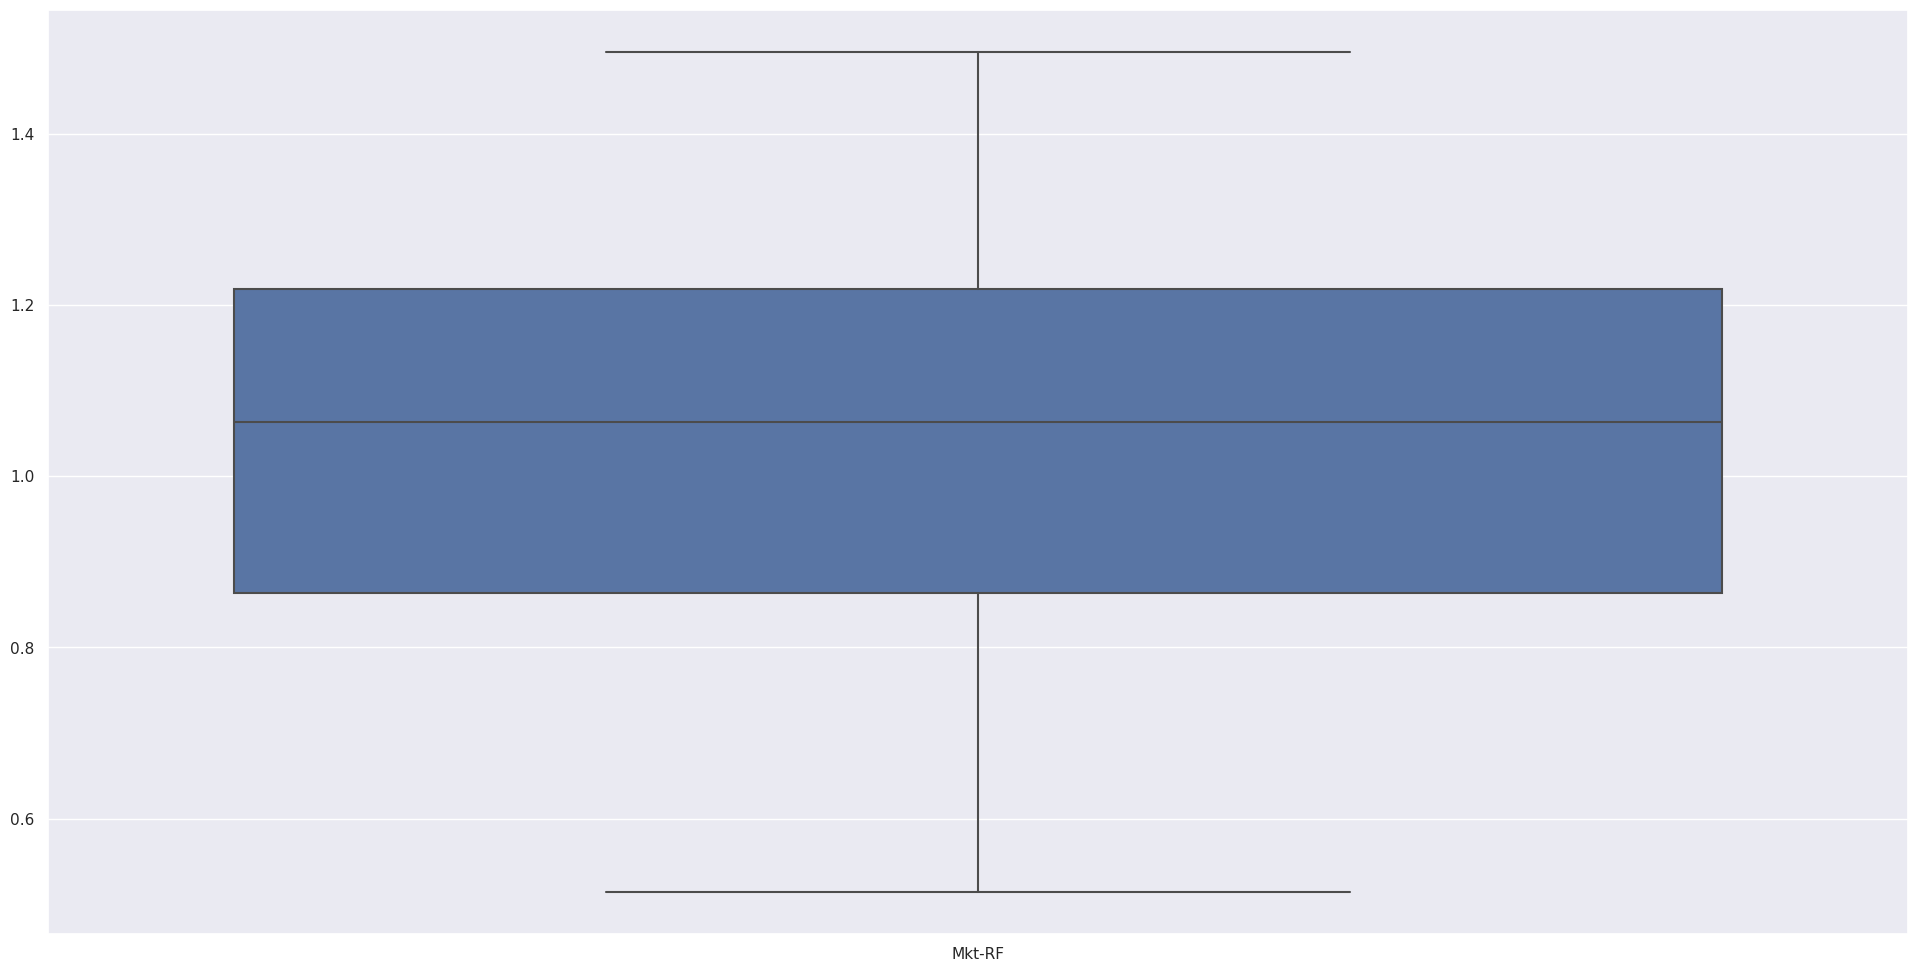

In [11]:
# 3FF HML Betas
toPlot=summaryGlobal.loc[(slice(None), "CAPM", "Coef."),["Mkt-RF"]].droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.boxplot(data=summaryGlobal.loc[(slice(None), "3FF", "Coef."),["Mkt-RF"]].droplevel(level=1).droplevel(level=1))
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/CAPM.png")

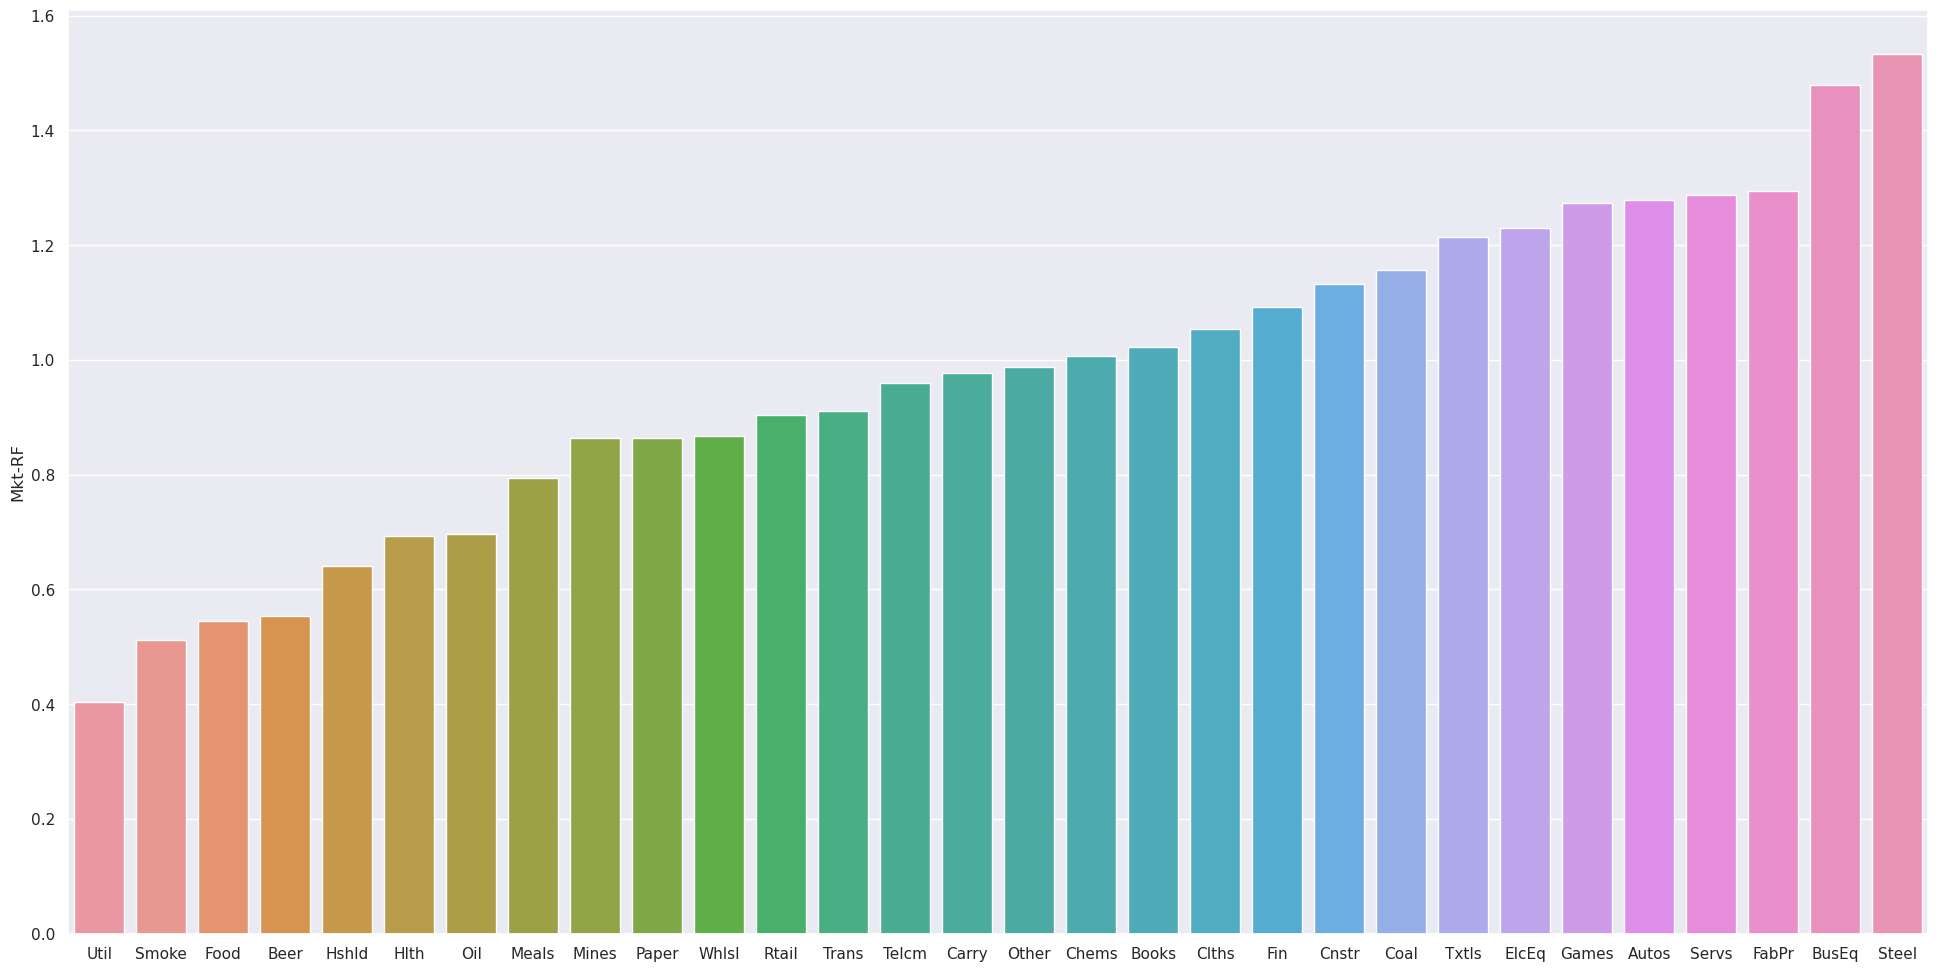

In [12]:
# CAPM Betas
toPlot=summaryGlobal.loc[(slice(None), "CAPM", "Coef."),"Mkt-RF"].sort_values().droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.barplot(x=toPlot.index,y=toPlot)
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/CAPMBetas.png")

### 3FF

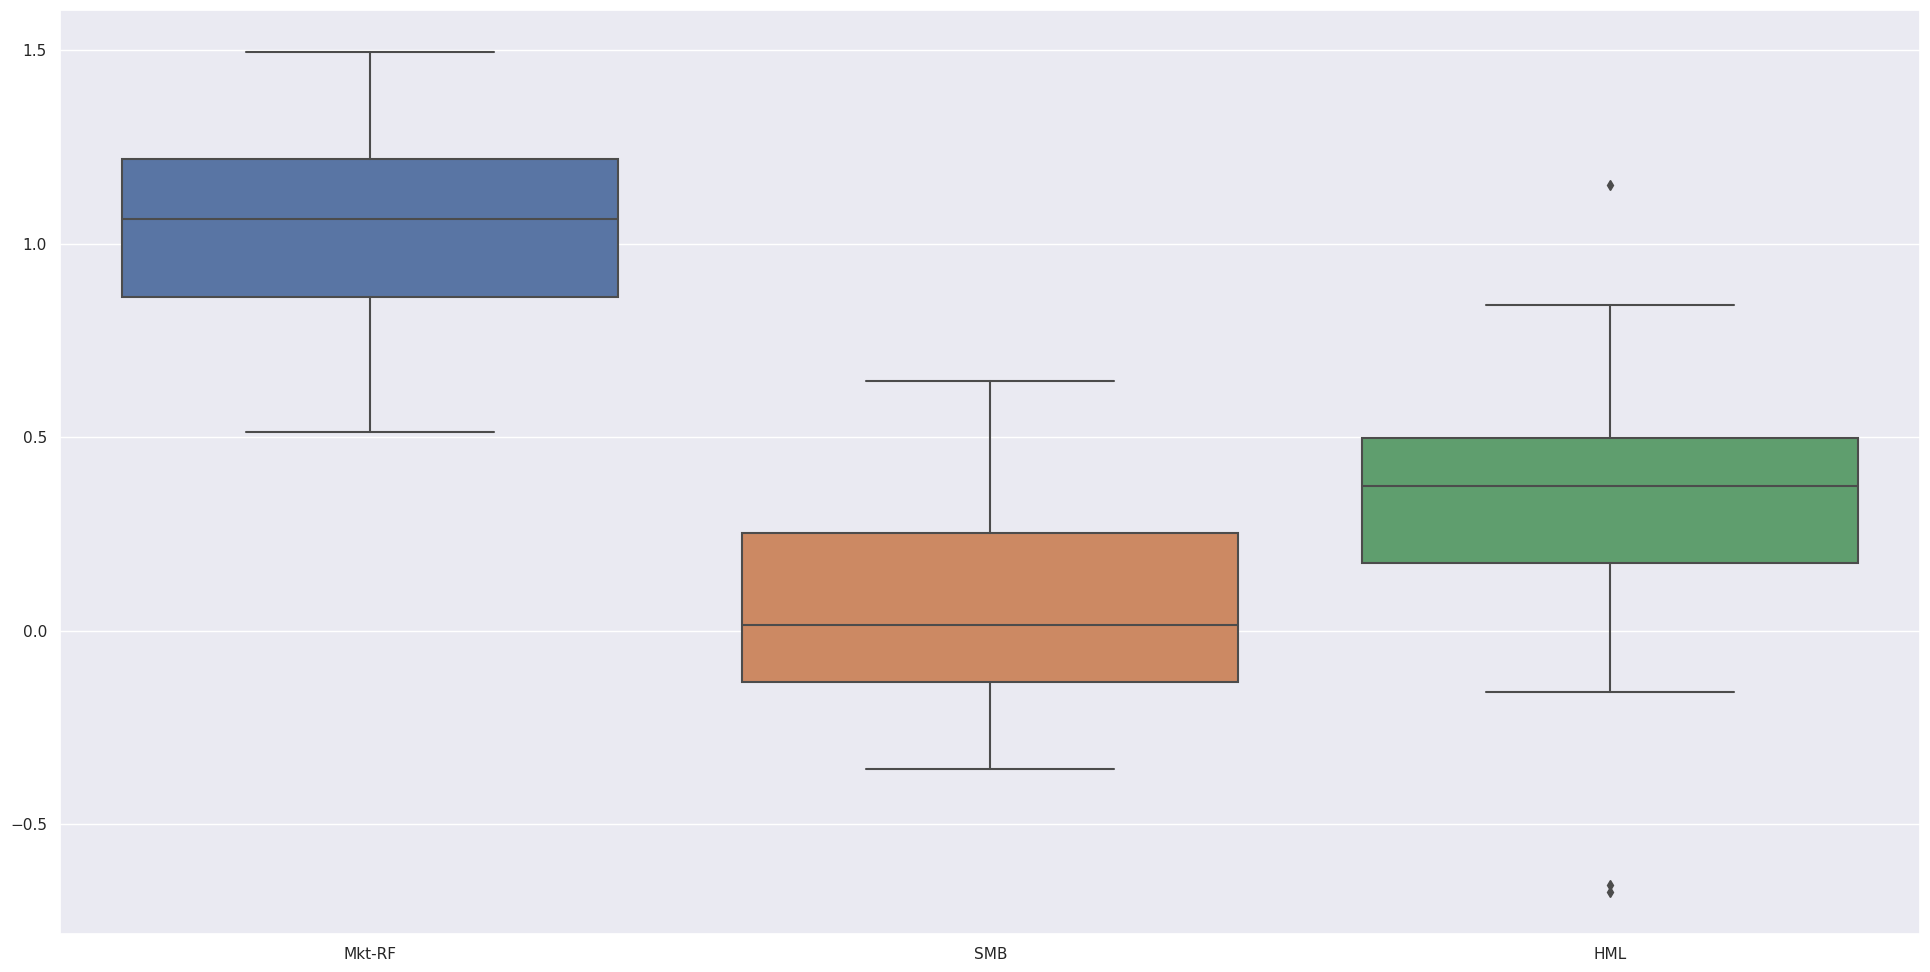

In [13]:
# 3FF HML Betas
toPlot=summaryGlobal.loc[(slice(None), "3FF", "Coef."),["Mkt-RF","SMB","HML"]].droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.boxplot(data=summaryGlobal.loc[(slice(None), "3FF", "Coef."),["Mkt-RF","SMB","HML"]].droplevel(level=1).droplevel(level=1))
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/3FF.png")

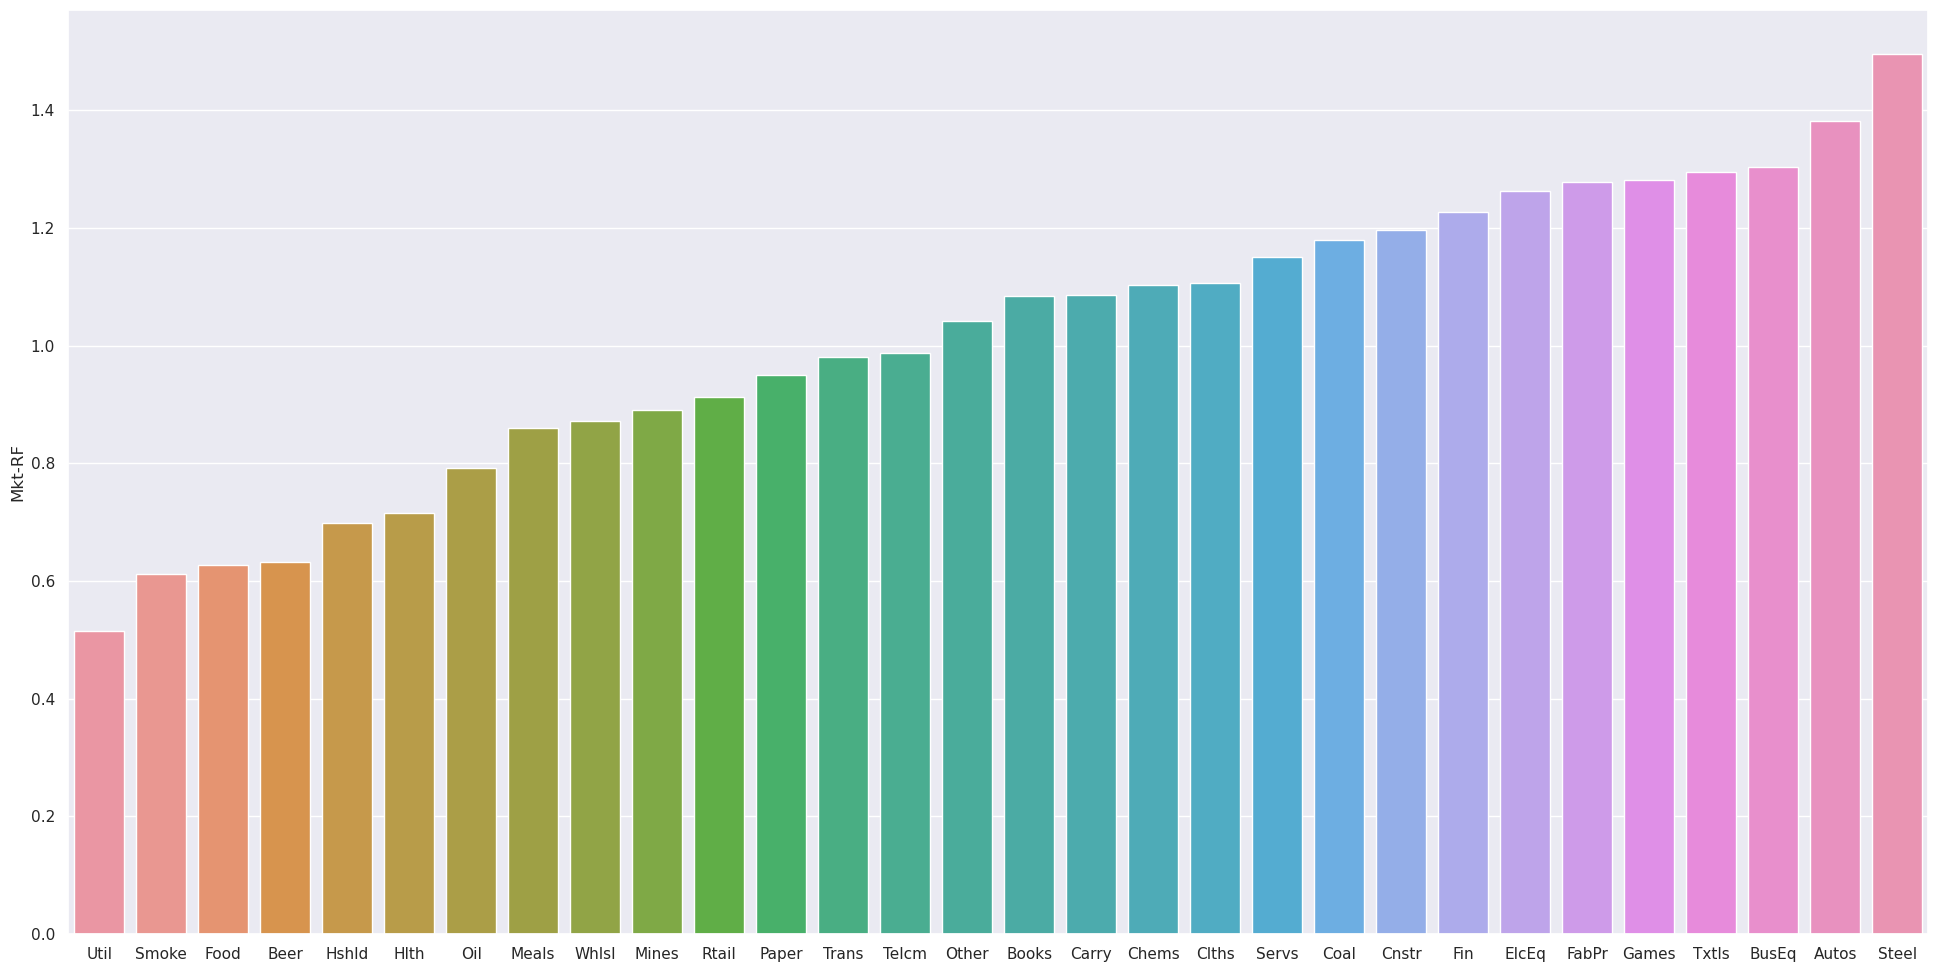

In [14]:
# 3FF Mkt Betas
toPlot=summaryGlobal.loc[(slice(None), "3FF", "Coef."),"Mkt-RF"].sort_values().droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.barplot(x=toPlot.index,y=toPlot)
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/3FFMktBetas.png")

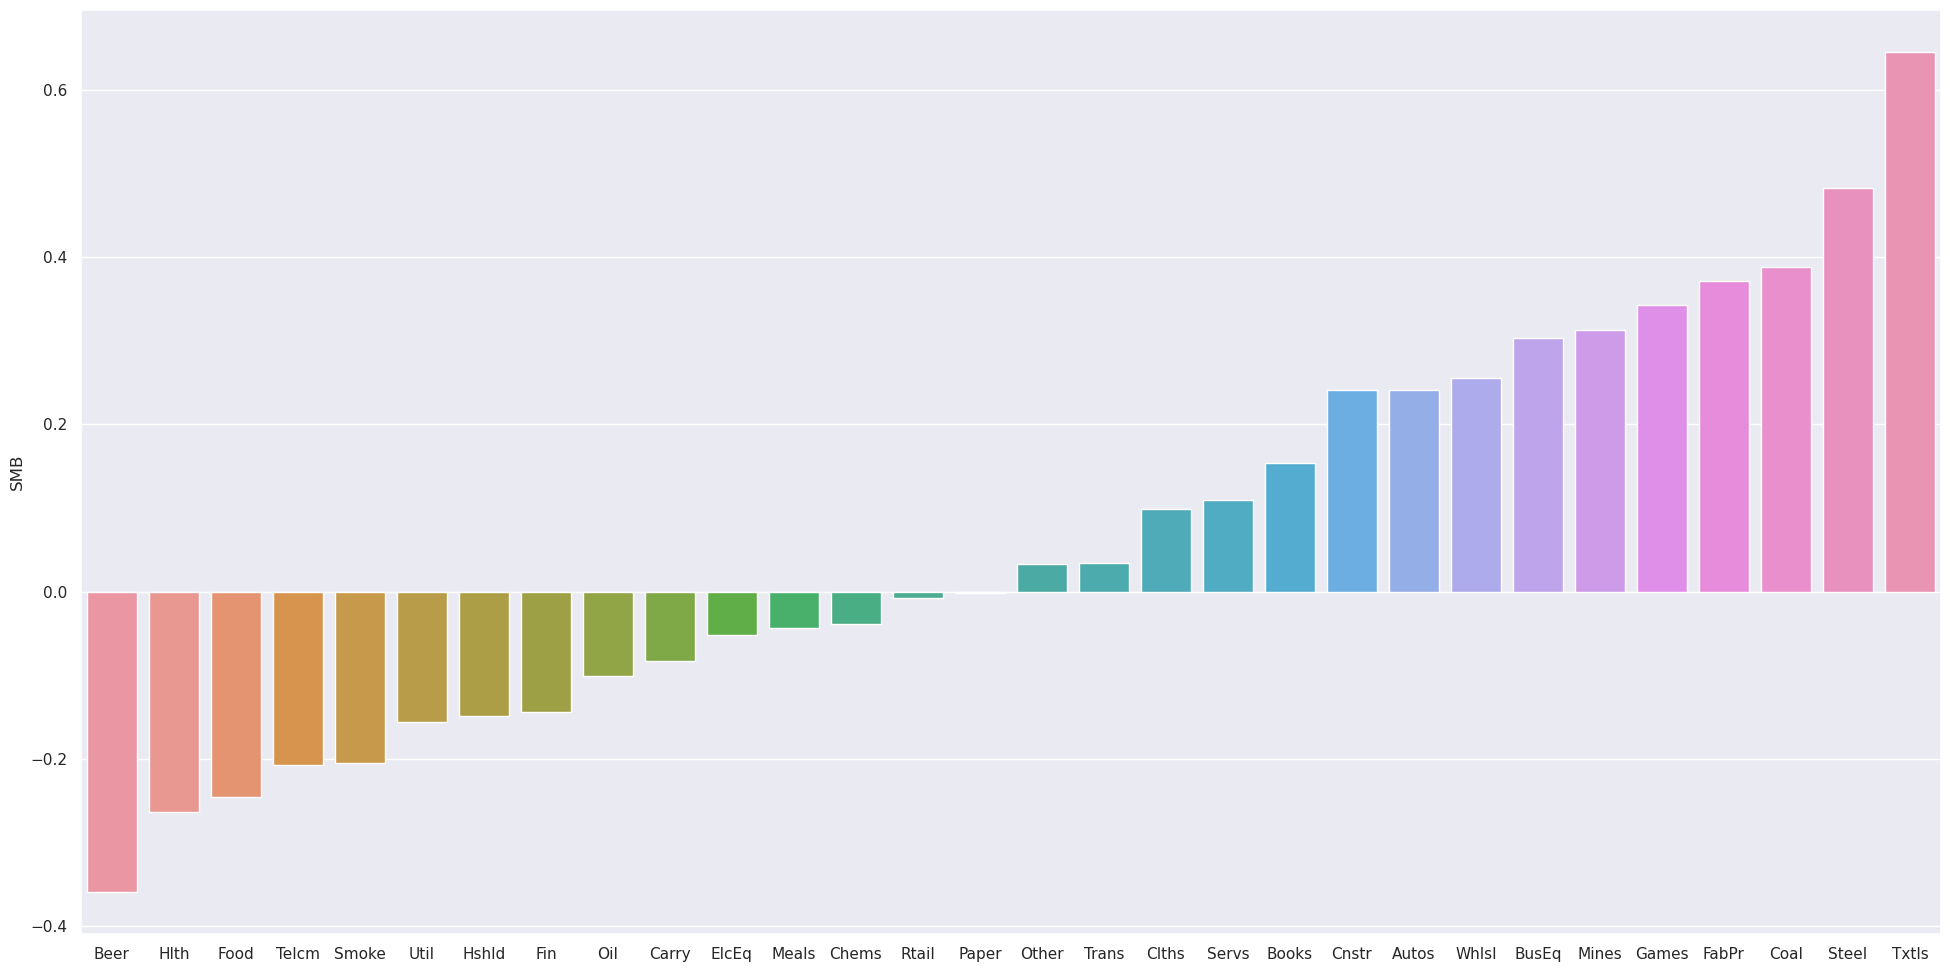

In [15]:
# 3FF SMB Betas
toPlot=summaryGlobal.loc[(slice(None), "3FF", "Coef."),"SMB"].sort_values().droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.barplot(x=toPlot.index,y=toPlot)
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/3FFSMBBetas.png")

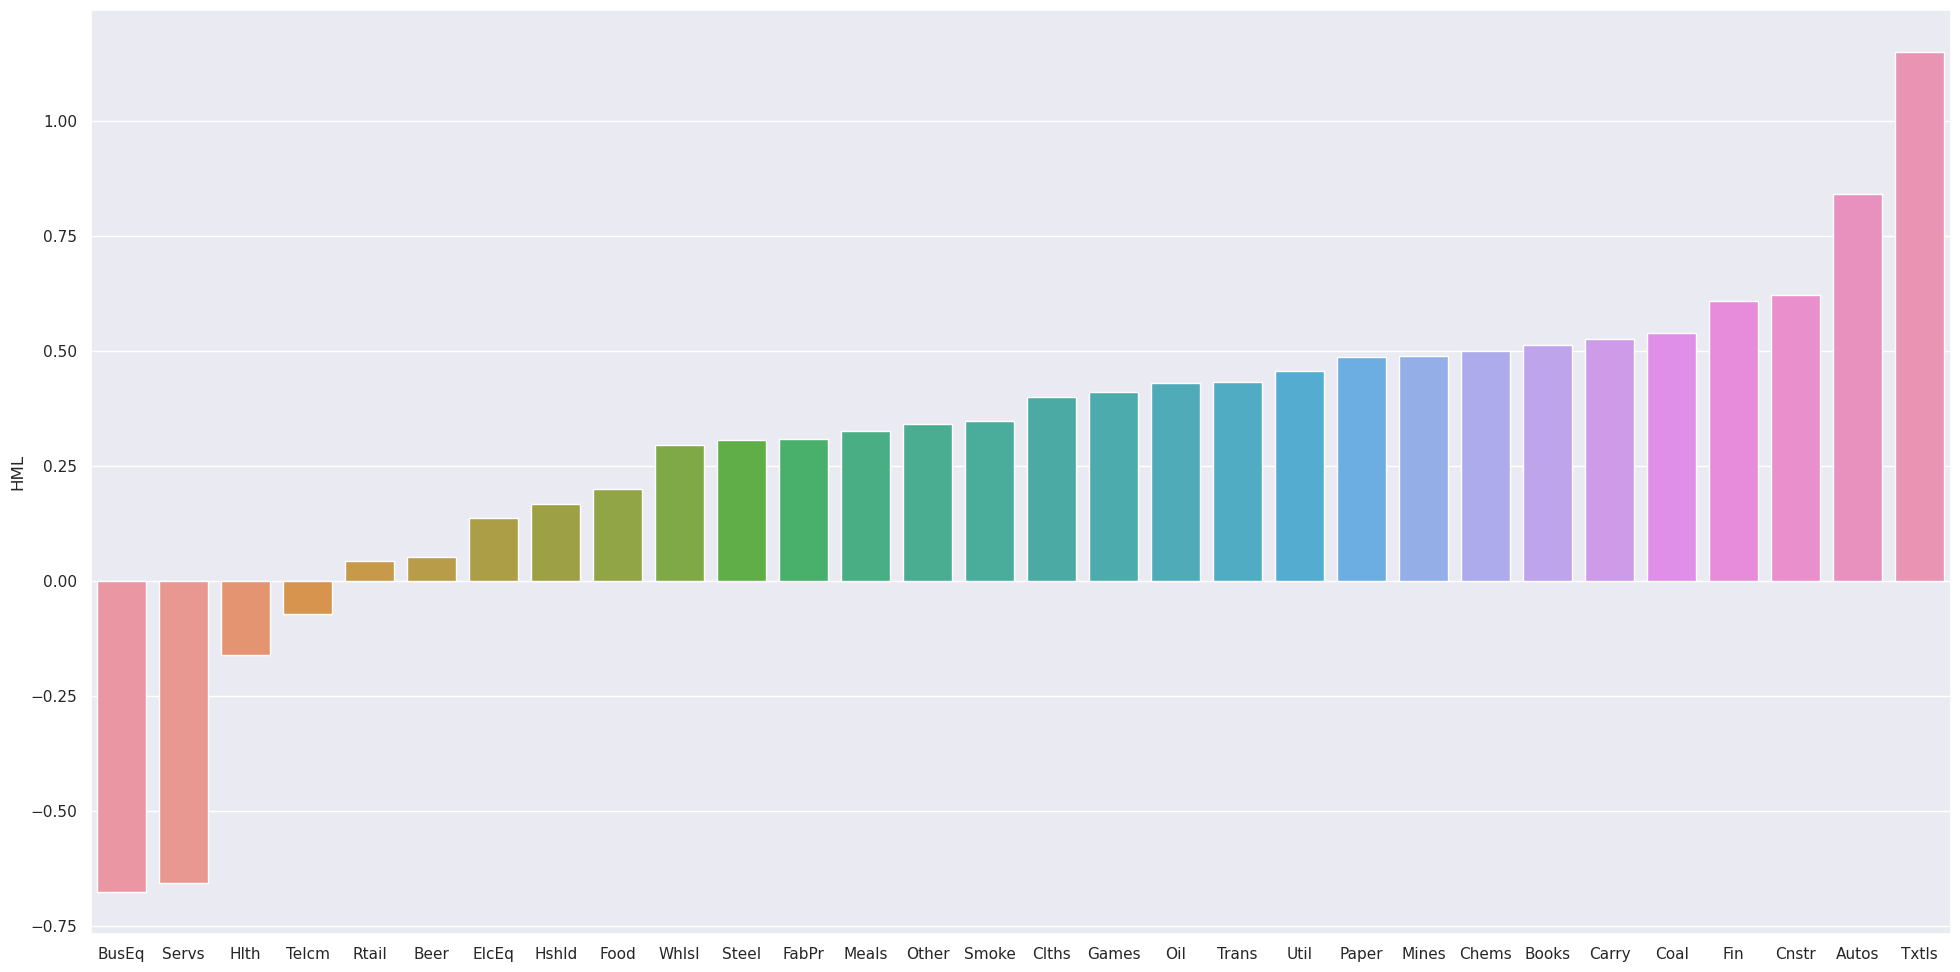

In [16]:
# 3FF HML Betas
toPlot=summaryGlobal.loc[(slice(None), "3FF", "Coef."),"HML"].sort_values().droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.barplot(x=toPlot.index,y=toPlot)
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/3FFHMLBetas.png")

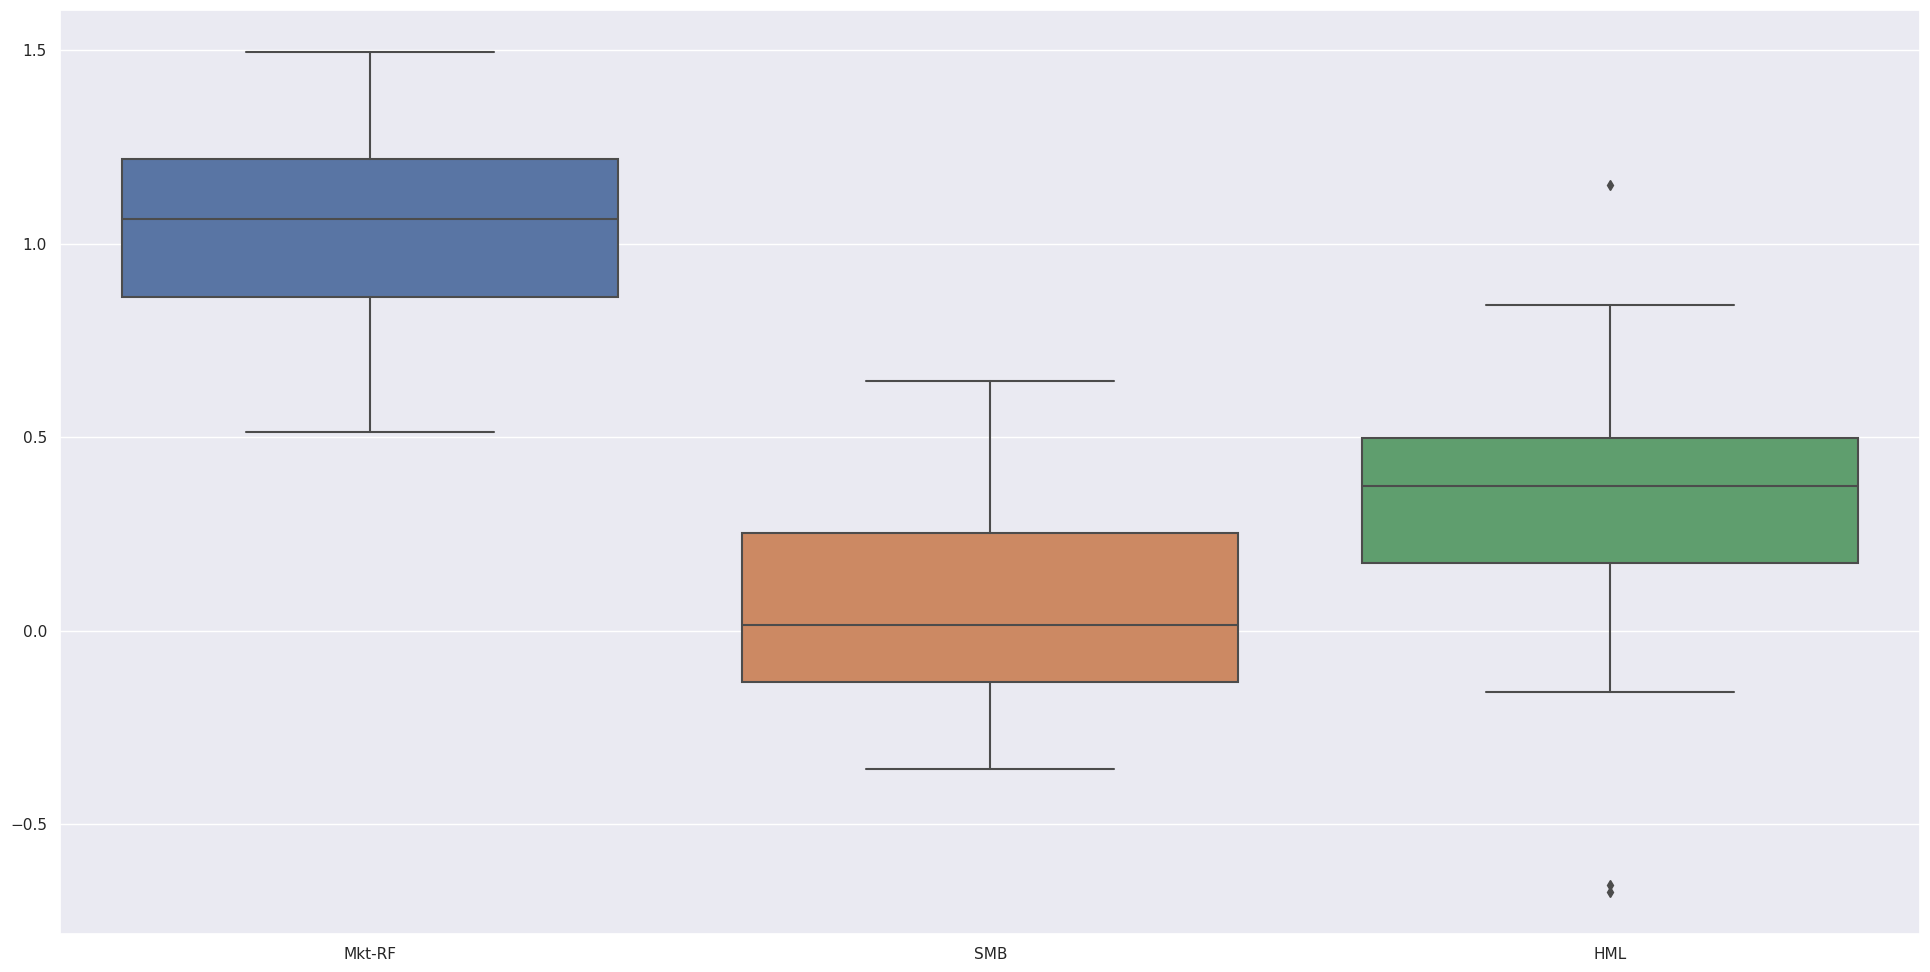

In [17]:
# 3FF HML Betas
toPlot=summaryGlobal.loc[(slice(None), "3FF", "Coef."),["Mkt-RF","SMB","HML"]].droplevel(level=1).droplevel(level=1)

sns.set(rc={"figure.figsize":(24, 12)})
sns_plot = sns.boxplot(data=summaryGlobal.loc[(slice(None), "3FF", "Coef."),["Mkt-RF","SMB","HML"]].droplevel(level=1).droplevel(level=1))
fig = sns_plot.get_figure()
fig.savefig(figuresPath+"/3FF.png")

In [18]:
import seaborn as sns
shap_values_contrib2 = pd.DataFrame(pd.DataFrame(data=SHAP_values_per_fold.values,columns=X.columns).abs().mean()).transpose().sort_values(by=0,axis=1,ascending=False)
sns.set(rc={"figure.figsize":(32, 18)})
sns_plot = sns.barplot(data=shap_values_contrib2)
sns_plot.set_xticklabels(sns_plot.get_xticklabels(), rotation=45, horizontalalignment='right')
fig = sns_plot.get_figure()

NameError: name 'SHAP_values_per_fold' is not defined

# Evaluation of industry portfolio performances

### Part I: Computation of industry portfolio using standard risk (-adjusted) measures

In [ ]:
portfoliosPerformances = pd.DataFrame(index=portfoliosTotalReturns.columns)
portfoliosPerformances["Volatility"] = portfoliosTotalReturns.std()*12**.5
portfoliosPerformances["Semi-vol"] = portfoliosTotalReturns[portfoliosTotalReturns<0].std()*12**.5
portfoliosPerformances["Sharpe ratio"] = portfoliosExcessReturns.mean()/(portfoliosExcessReturns.std()*12**.5)
portfoliosPerformances["Sortino ratio"] = portfoliosExcessReturns.mean()/(portfoliosExcessReturns[portfoliosExcessReturns<0].std()*12**.5)
portfoliosPerformances["Information ratio"] = (portfoliosTotalReturns.mean()-portfoliosTotalReturns["Mkt"].mean())/(portfoliosTotalReturns.sub(portfoliosTotalReturns["Mkt"], axis=0).std()*12**.5)

### Part II: Computation of industry portfolio using model-based risk (-adjusted) measures

In [ ]:
portfoliosPerformances["Treynor ratio"] = portfoliosExcessReturns.mean()/portfoliosCAPM["beta"]
portfoliosPerformances["Jensen's alpha"] = portfoliosCAPM["alpha"]
portfoliosPerformances["Appraisal alpha"] = portfoliosCAPM["alpha"]/portfoliosCAPM["standard error of the residual"]

In [ ]:
portfoliosPerformances

,Volatility,Semi-vol,Sharpe ratio,Sortino ratio,Information ratio,Treynor ratio,Jensen's alpha,Appraisal alpha
RF,0.006617,NaN,NaN,NaN,-0.041447,NaN,NaN,NaN
Mkt,0.150713,0.110185,0.041447,0.056367,NaN,NaN,NaN,NaN
Food,0.139496,0.092711,0.048394,0.072186,0.003718,0.012351,0.003329,0.102452
Beer,0.170229,0.122498,0.049085,0.067188,0.012861,0.015052,0.004877,0.113984
Smoke,0.236501,0.164769,0.042382,0.060484,0.016001,0.019578,0.006817,0.105547
Games,0.240790,0.181494,0.031645,0.042256,0.009114,0.005990,-0.000334,-0.007937
Books,0.194881,0.134473,0.021425,0.031370,-0.017336,0.004086,-0.002217,-0.064200
Hshld,0.148684,0.106913,0.046576,0.063766,0.005398,0.010809,0.002921,0.089354
Clths,0.224739,0.152596,0.037699,0.055014,0.014005,0.008050,0.001896,0.041140
Hlth,0.153279,0.093155,0.053614,0.085662,0.016131,0.011816,0.003861,0.119751
